<a href="https://colab.research.google.com/github/Lokeshdawkare/Lokeshdawkare/blob/main/Image_Segmentation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:

import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
import cv2
import numpy as np
from keras.utils import load_img, img_to_array


In [13]:


# Create directories for images and masks
os.makedirs('shapes/images', exist_ok=True)
os.makedirs('shapes/masks', exist_ok=True)

# Function to create images with shapes
def create_shape_image(shape, img_size=(128, 128), color=(255, 255, 255)):
    image = np.zeros((img_size[0], img_size[1], 3), dtype=np.uint8)
    mask = np.zeros((img_size[0], img_size[1]), dtype=np.uint8)

    if shape == 'circle':
        cv2.circle(image, (64, 64), 40, color, -1)
        cv2.circle(mask, (64, 64), 40, 255, -1)

    elif shape == 'square':
        cv2.rectangle(image, (24, 24), (104, 104), color, -1)
        cv2.rectangle(mask, (24, 24), (104, 104), 255, -1)

    elif shape == 'triangle':
        pts = np.array([[64, 20], [20, 110], [110, 110]], np.int32)
        cv2.fillPoly(image, [pts], color)
        cv2.fillPoly(mask, [pts], 255)

    return image, mask

# Create and save the dataset
shapes = ['circle', 'square', 'triangle']
num_samples = 20

for shape in shapes:
    for i in range(num_samples):
        img, mask = create_shape_image(shape, color=(255, 255, 255))
        cv2.imwrite(f'shapes/images/{shape}_{i}.png', img)
        cv2.imwrite(f'shapes/masks/{shape}_{i}_mask.png', mask)

print("Dataset created!")


Dataset created!


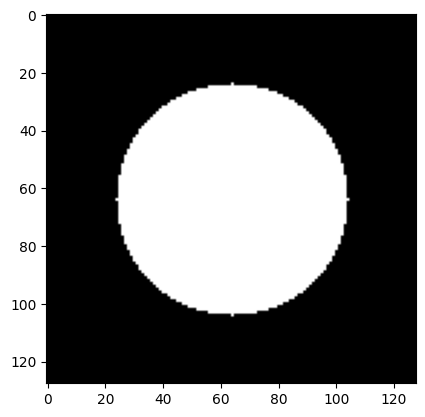

In [14]:
# prompt: print sample images just one

import matplotlib.pyplot as plt
import cv2

img = cv2.imread('shapes/images/circle_0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()


In [15]:
def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []

    for img_name in os.listdir(image_dir):
        # Load and preprocess images
        img = load_img(os.path.join(image_dir, img_name), target_size=img_size)
        img = img_to_array(img) / 255.0  # Normalize the image
        images.append(img)

        # Load and preprocess masks
        mask_name = img_name.split('.')[0] + '_mask.png'  # Mask naming convention
        mask = load_img(os.path.join(mask_dir, mask_name), target_size=img_size, color_mode='grayscale')
        mask = img_to_array(mask) / 255.0  # Normalize the mask
        masks.append(mask)

    return np.array(images), np.array(masks)

# Define paths to your created dataset
image_dir = 'shapes/images'
mask_dir = 'shapes/masks'

# Load the dataset
X, y = load_data(image_dir, mask_dir)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
def build_simple_unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder (Downsampling)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)

    # Decoder (Upsampling)
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Concatenate()([up4, conv2])
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(up4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Concatenate()([up5, conv1])
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(up5)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs, outputs)
    return model

# Build the U-Net model
model = build_simple_unet()


In [17]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.8105 - loss: 0.6144 - val_accuracy: 0.9633 - val_loss: 0.3712
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9727 - loss: 0.2941 - val_accuracy: 0.9785 - val_loss: 0.0774
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9865 - loss: 0.0473 - val_accuracy: 0.9914 - val_loss: 0.0251
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9939 - loss: 0.0179 - val_accuracy: 0.9939 - val_loss: 0.0182
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9956 - loss: 0.0137 - val_accuracy: 0.9984 - val_loss: 0.0063
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9981 - loss: 0.0075 - val_accuracy: 0.9976 - val_loss: 0.0071
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9975 - loss: 0.0070 - val_accuracy: 0.9990 - val_loss: 0.0051
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9986 - loss: 0.0053 - val_accuracy: 0.9991 - val_loss: 0.0045

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
Mean IoU: 0.9973


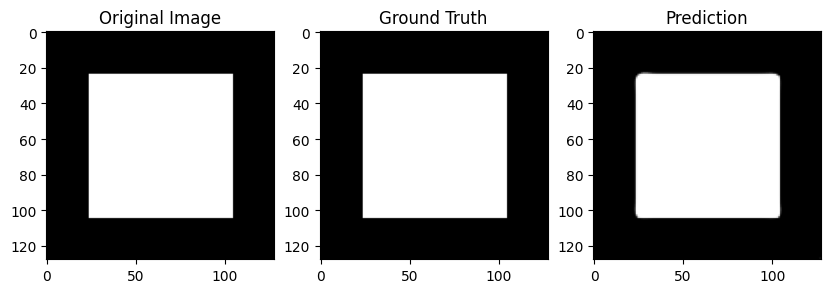

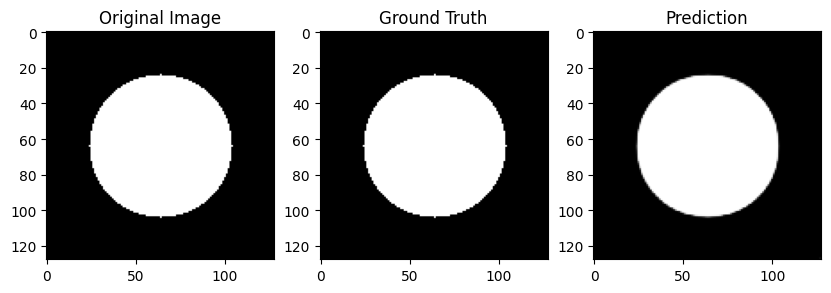

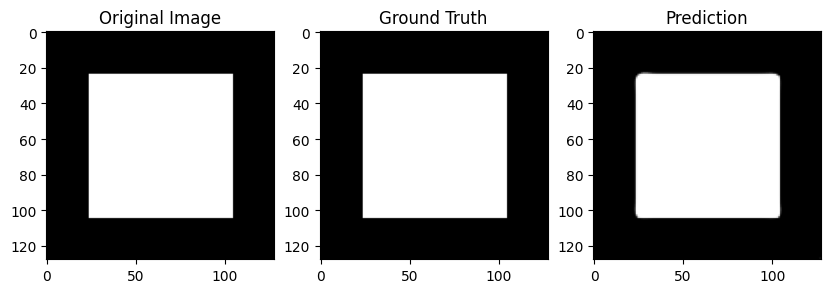

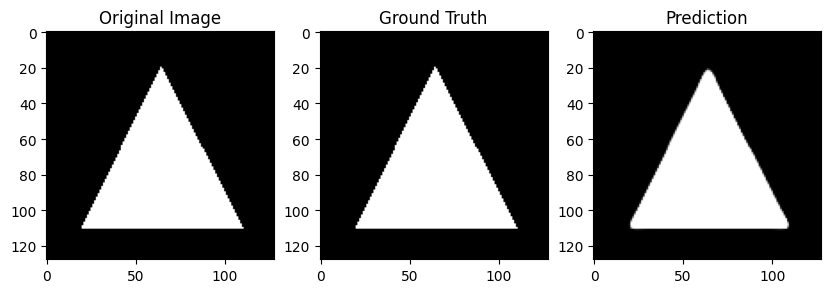

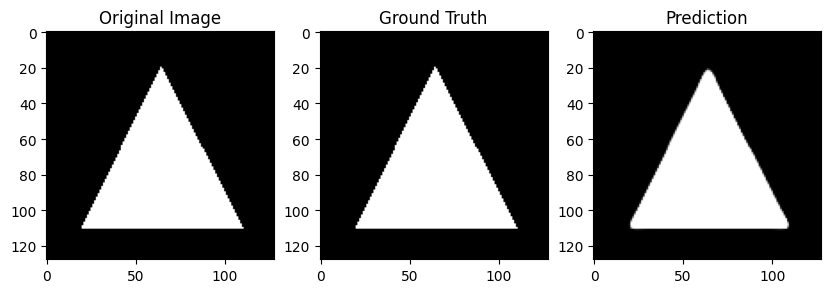

In [18]:
# Function to calculate IoU
def calculate_iou(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(int)  # Thresholding
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    return np.sum(intersection) / np.sum(union)

# Predict on validation data
y_pred = model.predict(X_val)

# Calculate Mean IoU
iou_scores = [calculate_iou(y_val[i].squeeze(), y_pred[i].squeeze()) for i in range(len(y_val))]
mean_iou = np.mean(iou_scores)
print(f"Mean IoU: {mean_iou:.4f}")

# Visualization function
def visualize_results(image, ground_truth, prediction):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth.squeeze(), cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Prediction')

    plt.show()

# Visualize predictions for the first 5 images
for i in range(5):
    visualize_results(X_val[i], y_val[i], y_pred[i])
